In [24]:
# granting access to csv file

from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/SaMD/diseaseProbs.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# loading data

import pandas as pd

# probability lookup table
prob_df = pd.read_csv(csv_path, delimiter=';')
print(prob_df)


          disease  fever  respiratory_symptoms  sneeze  cough  runny_nose  \
0        covid-19   1.00                  1.00    0.00   1.00        0.00   
1             flu   0.75                  0.75    1.00   0.75        1.00   
2     common_cold   0.50                  0.75    0.75   0.75        0.75   
3      bronchitis   0.50                  0.75    0.00   0.75        0.00   
4             RSV   0.50                  0.75    0.00   0.75        0.75   
5  pollen_allergy   0.25                  0.25    0.50   0.25        0.25   
6       sinusitis   0.50                  0.75    0.00   0.50        0.75   
7       hay_fever   0.50                  0.75    1.00   0.75        1.00   

   muscle_aches  headache  fatigue  diarrhea  vomiting  chest_pain  \
0          0.75      1.00     0.75      0.75      0.75        0.75   
1          1.00      0.75     1.00      1.00      1.00        0.00   
2          0.00      0.50     0.00      0.00      0.00        0.00   
3          0.00      0.00 

In [26]:
# generating synthetic dataset of n samples

import numpy as np

# generates a dataset of n samples (row structure: disease1 | symptom1 = True/False | symptom2 = True/False | ...)
# based on the probability of each symptom occurring in the respective disease
# prob_df: the dataset that contains the symptom probability for each disease
# n_samples: number of samples to create
def generate_synthetic_data(prob_df, n_samples=1000):
    data = [] # will contain all created samples
    diseases = prob_df['disease'].tolist() # all diseases
    symptoms = prob_df.columns[1:].tolist() # all symptoms

    for _ in range(n_samples):
        disease = np.random.choice(diseases) # picks a random disease from the list of possible diseases
        symptom_probs = prob_df[prob_df['disease'] == disease].iloc[0, 1:].tolist() # saves the probability of every symptom for the picked disease in a list
        symptoms_present = [np.random.rand() < prob for prob in symptom_probs] # creates data for a new sample: decides for every symptom if it´s present (value=True) or not (value=False); the decision is based on the probability of that symptom
        data.append(symptoms_present + [disease]) # creates the actual sample: concatenates the created sample data with the name of the picked disease and puts it in "data"

    return pd.DataFrame(data, columns=symptoms + ['disease'])

df = generate_synthetic_data(prob_df, n_samples=1000)
print(df.head())


   fever  respiratory_symptoms  sneeze  cough  runny_nose  muscle_aches  \
0  False                  True   False   True       False         False   
1  False                 False    True  False       False         False   
2  False                  True   False   True        True         False   
3   True                  True   False  False        True          True   
4   True                 False   False   True       False         False   

   headache  fatigue  diarrhea  vomiting  chest_pain  stomachache  \
0     False    False     False     False        True        False   
1     False     True     False      True       False        False   
2     False    False     False     False       False        False   
3      True     True      True     False       False         True   
4     False    False     False     False       False        False   

   sore_throat  itchy_eyes  loss_of_appetite  loss_of_sense_of_smell  \
0        False       False             False                  

symptom_columns: 
 
      fever  respiratory_symptoms  sneeze  cough  runny_nose  muscle_aches  \
0    False                  True   False   True       False         False   
1    False                 False    True  False       False         False   
2    False                  True   False   True        True         False   
3     True                  True   False  False        True          True   
4     True                 False   False   True       False         False   
..     ...                   ...     ...    ...         ...           ...   
995   True                  True   False   True        True         False   
996   True                 False    True  False       False         False   
997  False                  True   False   True       False         False   
998  False                  True   False   True       False         False   
999   True                  True   False  False       False         False   

     headache  fatigue  diarrhea  vomiting  chest_pain

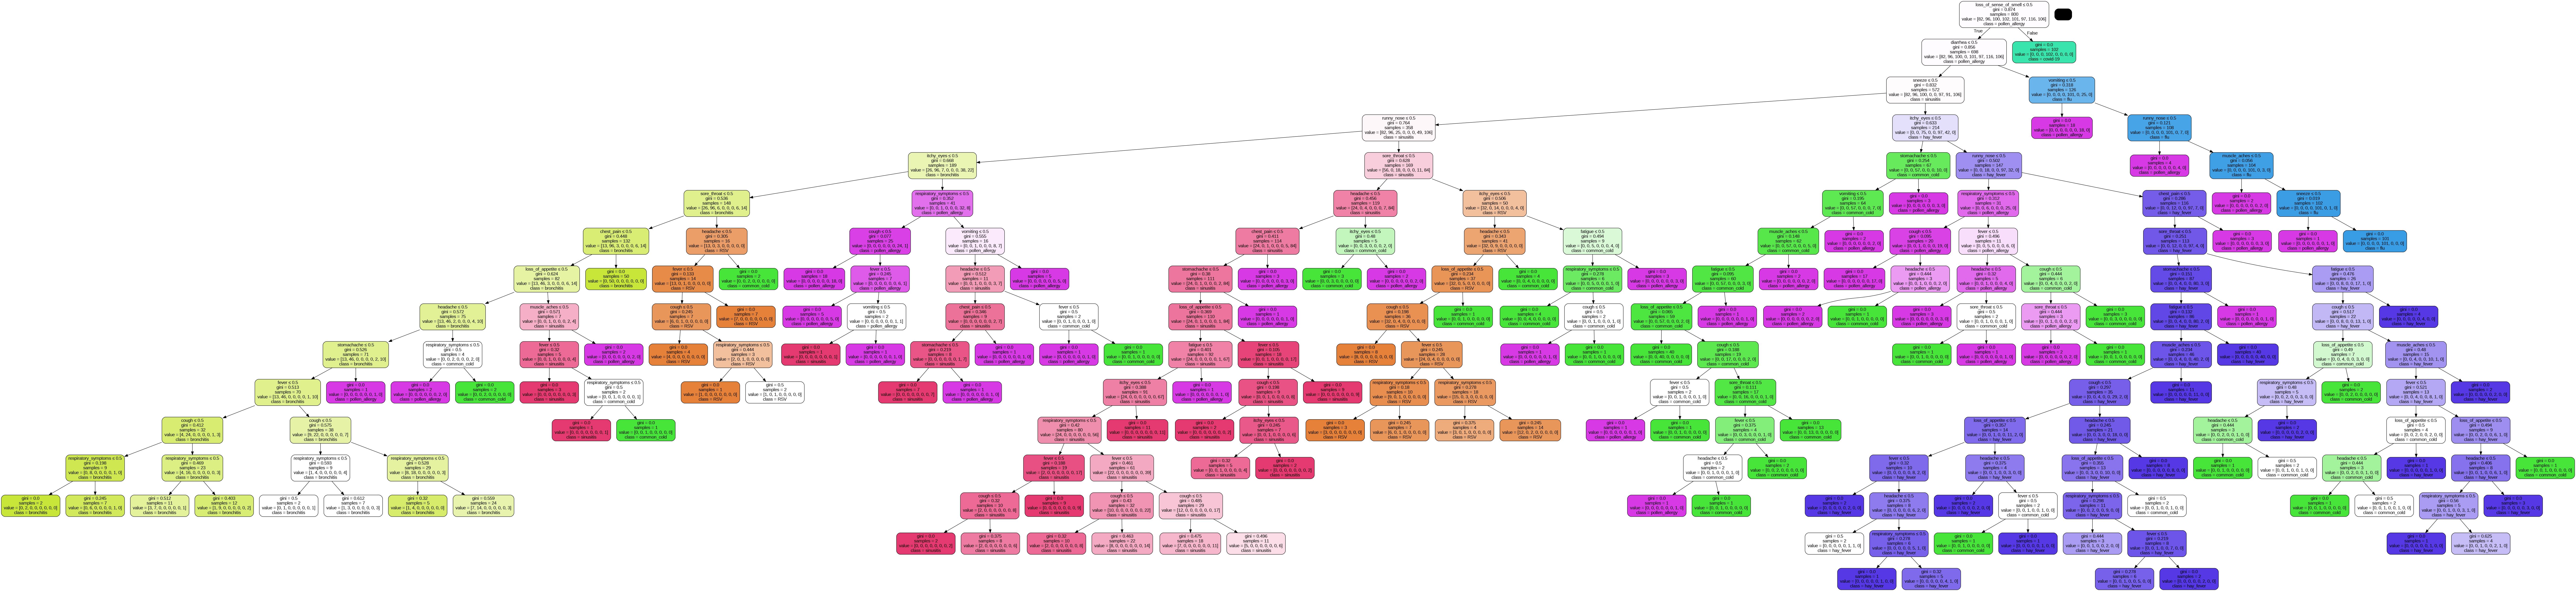

In [27]:
# training and visualizing the decision tree

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import graphviz
import pydotplus
from IPython.display import Image

## prepare the data
symptom_columns = df.drop(columns=['disease']) # contains the symptom values (True or False) for each sample
print(f"symptom_columns: \n \n {symptom_columns} \n")
disease_column = df['disease'] # contains the corresponding disease for each sample
print(f"disease_column: \n \n {disease_column}")

## split the data
### the data is split into two parts:
### 80% of the prepared dataset will be used to train the decision tree
### 20% of the prepared dataset will be used to test how good the created decision tree performs
X_train, X_test, y_train, y_test = train_test_split(symptom_columns, disease_column, test_size=0.2, random_state=42)

## train the decision tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

## predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

## visualize the decision tree
dot_data = export_graphviz(clf, out_file=None,
                           feature_names=symptom_columns.columns,
                           class_names=clf.classes_,
                           filled=True, rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# opt. save the tree visualization to file
# graph.write_png("decision_tree.png")

In [36]:
# using the decision tree

## collecting the correct symptoms

### initialize all symptoms with False
symptom_dict = {"respiratory_symptoms": False, "fever": False, "sneeze": False,
                  "cough": False, "runny_nose": False, "muscle_aches": False, "headache": False,
                  "fatigue": False, "diarrhea": False, "vomiting": False, "chest_pain": False,
                  "stomachache": False, "sore_throat": False, "itchy_eyes": False,
                  "loss_of_appetite": False, "loss_of_sense_of_smell": False}

### collect user symptoms
user_symptoms = [
    {
        "title": "fever",
        "id": 0
    },
    {
        "title": "sneeze",
        "id": 2
    }
]

### change value of existing user symptoms to True
for symptom in user_symptoms:
  symptom_name = symptom["title"]
  if(symptom_name) in symptom_dict:
    symptom_dict[symptom_name] = True

### convert the symptoms to a DataFrame
input_df = pd.DataFrame([list(symptom_dict.values())], columns=symptom_columns.columns)
print(input_df)

## predicting the disease with the DecisionTreeClassifier
predicted_disease = clf.predict(input_df)
print(f'The predicted disease is: {predicted_disease[0]}')

   fever  respiratory_symptoms  sneeze  cough  runny_nose  muscle_aches  \
0  False                  True    True  False       False         False   

   headache  fatigue  diarrhea  vomiting  chest_pain  stomachache  \
0     False    False     False     False       False        False   

   sore_throat  itchy_eyes  loss_of_appetite  loss_of_sense_of_smell  
0        False       False             False                   False  
The predicted disease is: common_cold
